# Reinforcement Learning: Hands-on-project



### student: Hannah Schult (5373022)

### Goal: In this notebook, the agent will be trained using Q-tables to solve the FrozenLake game. 

sources: https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/#sphx-glr-tutorials-training-agents-frozenlake-tuto-py

References:

-  Code inspired from [Deep Reinforcement Learning
   Course](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/)_
   by Thomas Simonini (http://simoninithomas.com/)
-  [Dissecting Reinforcement
   Learning-Part.2](https://mpatacchiola.github.io/blog/2017/01/15/dissecting-reinforcement-learning-2.html)_
-  [Dadid Silver’s course](https://www.davidsilver.uk/teaching/)_ in
   particular lesson 4 and lesson 5
-  [Q-learning article on
   Wikipedia](https://en.wikipedia.org/wiki/Q-learning)_
-  [Q-Learning: Off-Policy TD
   Control](http://incompleteideas.net/book/ebook/node65.html)_ in
   [Reinforcement Learning: An Introduction, by Richard S. Sutton and
   Andrew G. Barto](http://incompleteideas.net/book/ebook/)_
-  [Epsilon-Greedy
   Q-learning](https://www.baeldung.com/cs/epsilon-greedy-q-learning)_
-  [Introduction to Reinforcement
   Learning](https://gibberblot.github.io/rl-notes/index.html)_ by Tim
   Miller (University of Melbourne)



## Imports




In [3]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

## Parameter Configuration




In [4]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./img"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

## FrozenLake




In [5]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

### Q-Tables

Q-Tables are a fundamental concept in Reinforcement Learning. The agent learns by interacting with its environment to maximize its rewards. The Q-Table stores the expected reward that the agent can receive for each state-action pair, representing the potential outcomes of taking a specific action in a given state. Throughout the learning process, the table is iteratively updated as the agent gains experience, and the obtained rewards are assigned to the corresponding entries in the table. This way, the agent can develop an optimal strategy to make the best decisions in its environment and achieve high rewards.



In [6]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))



#The EpsilonGreedy class implements a strategy for selecting actions for the agent based
#on the Epsilon-Greedy approach. This method allows for a balance between 
#exploration (exploring unknown actions) and exploitation (exploiting known good actions).
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


### run the environment

instantiate the learner and explorer




In [7]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [8]:
#Function to run our environment until the maximum number of episodes params.total_episodes.
#To account for stochasticity, we will also run our environment a few times.
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

### Visualizations




In [9]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

To visualize the policies, we need to:

- Extract the best Q-values from the Q-table for each state.
- Determine the corresponding best action for these Q-values.
- Map each action to an arrow to represent them visually.




In [10]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [11]:
#With the following function, we will display the last frame of the simulation on the left side. 
#If the agent has learned a good policy to solve the task, we expect the agent to be located 
#on the target tile. On the right side, we will visualize the policy that the agent has learned. 
#Each arrow represents the best action to be chosen for each tile/state

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [12]:
#Sanity check: A chart representing the distribution of states and actions.

def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 7x7


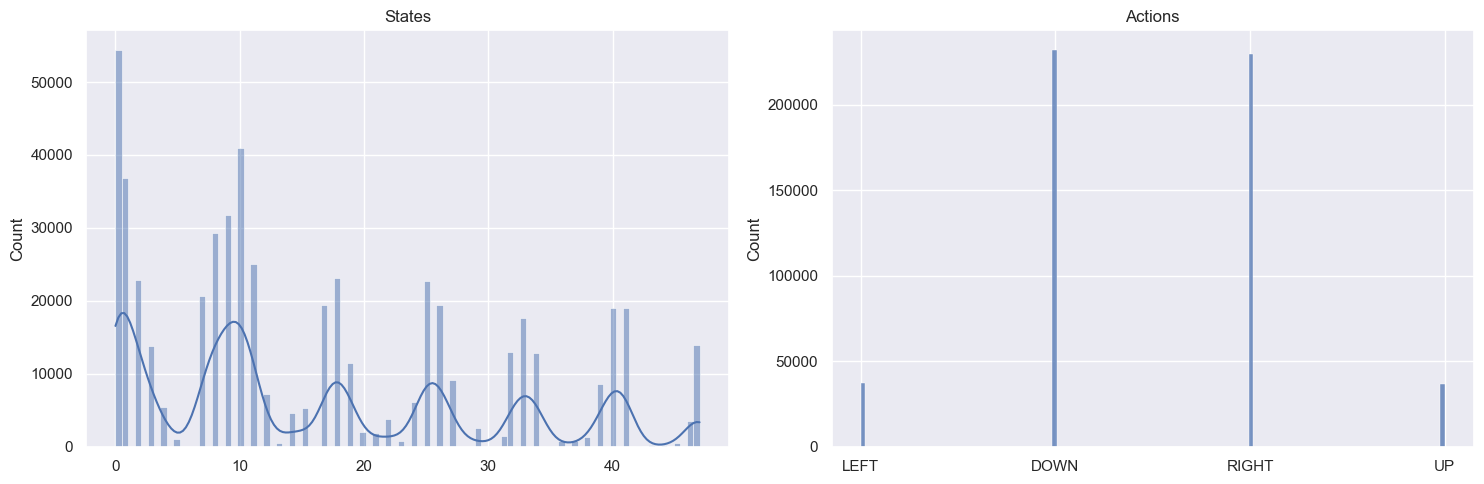

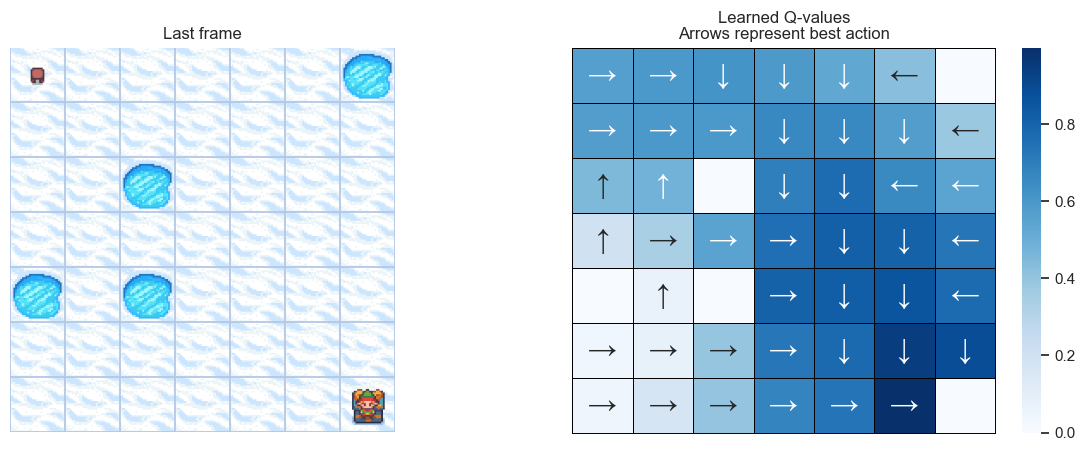

In [14]:
map_size = 7
res_all = pd.DataFrame()
st_all = pd.DataFrame()


env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=map_size, p=params.proba_frozen, seed=params.seed
    ),
)

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
env.action_space.seed(
    params.seed
)  # Set the seed to get reproducible results when sampling the action space
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

print(f"Map size: {map_size}x{map_size}")
rewards, steps, episodes, qtables, all_states, all_actions = run_env()

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps, map_size)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

plot_states_actions_distribution(
    states=all_states, actions=all_actions, map_size=map_size
)  # Sanity check
plot_q_values_map(qtable, env, map_size)

env.close()

--> The actions "DOWN" and "RIGHT" are selected more often --> this is because the agent starts in the upper left corner and needs to move to the lower right corner --> to follow this path, it has to take the actions "DOWN" and "RIGHT".

## Trainings Evaluation

To verify if the agent is learning, we can monitor two important metrics:

The cumulative sum of rewards: If the agent is improving its policy and making better decisions, it should receive higher rewards over time. The cumulative sum of rewards should increase as the agent learns from its experiences.

The number of steps taken until the end of the episode: As the agent learns to navigate the environment more efficiently, it should take fewer steps to reach the terminal state or complete the task in each episode. Thus, the number of steps taken should decrease as the agent becomes more proficient.

By tracking these metrics during the training process, we can observe how well the agent is learning and whether its policy is improving over time.







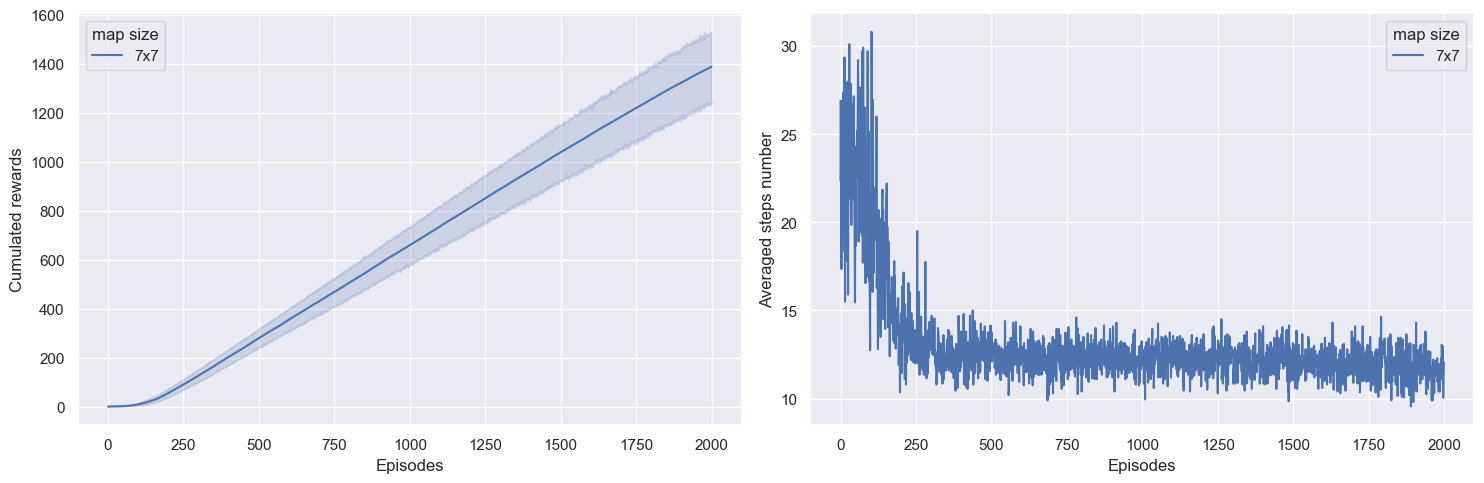

In [ ]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

--> The agent is improving during training, as evidenced by the increasing cumulative sum of rewards (left) and the decreasing number of steps taken until the end of episodes (right). After approximately 300 episodes, the average number of steps per episode stabilizes, indicating that the agent has learned an efficient policy and is consistently navigating the environment effectively.